# Simple Fixed Income Market

by Thomas Krabichler

## Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
images_dir=''

## Model Parameters

In [3]:
# TIME GRID

N=12*20
time_grid_plain=np.linspace(0,N,N+1)
time_grid_dcc=time_grid_plain/12 # year-count-convention

# BALANCE SHEET PARAMETERS

# assets
A0=100
# liabilities (constant deposits)
L0=50

# control the total swap volume
penalty=0.1

## Objective

In [4]:
# OPTIMIZATION PARAMETERS

target_month=120

# loss function
target_equity=70

# size of training and validation set
nScenarios=10**3
nValidation=10**3

## Term Structure Model

In this section, we rely on historical ECB yield curve data. The mathematical framework of the Svensson parameterisation and the principal component analysis can be found in the Sections 3.3.3 - 3.4 of the textbook «Term Structure Models» by Damir Filipovic. Please be aware of Proposition 9.5 in the same book.

In [5]:
# YIELD CURVE PARAMETERS

index_yc=2135 # 31-Dec-2012

# YIELD CURVE DYNAMICS

# data import
path=''
ECB=pd.read_csv(images_dir+'201231_ECB.csv')

# zero-coupon bond prices for maturity T in years and Svensson parameter z
def ZCB_prices(T,z):
    return np.exp(-1/100*(z[0]*T-(z[1]/z[4]+z[2]/z[4]**2)*(np.exp(-z[4]*T)-1)-\
        z[2]/z[4]*T*np.exp(-z[4]*T)-z[3]/z[5]*T*np.exp(-z[5]*T)-z[3]/z[5]**2*\
        (np.exp(-z[5]*T)-1)))

# historical discount factors for a time grid
vec_ZCB_prices=np.vectorize(ZCB_prices,excluded=[1])

# yields for historical day i
def hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    shift=0 if rating=='AAA' else 6
    z=[ECB.loc[i,:][1+shift],ECB.loc[i,:][2+shift],ECB.loc[i,:][3+shift]/\
        ECB.loc[i,:][5+shift],ECB.loc[i,:][4+shift]/ECB.loc[i,:][6+shift],1/\
        ECB.loc[i,:][5+shift],1/ECB.loc[i,:][6+shift]]
    return np.divide(-np.log(vec_ZCB_prices(grid,z)),grid)

# collection of historical yields
def vec_hist_yc(i,grid=time_grid_dcc[1:],rating='AAA'):
    output=hist_yc(i[0],grid,rating)
    for j in i[1:]:
        output=np.vstack((output,hist_yc(j,grid,rating)))
    return output

# transform yields into discount factors
def discounting(yields,terms):
    return np.exp(-yields*terms)

# PCA
hist_increments=vec_hist_yc(range(1,index_yc))-vec_hist_yc(range(0,index_yc-1))
PCA_mu=np.mean(hist_increments,axis=0)
PCA_Q=np.cov(hist_increments,rowvar=False)
PCA_lambda,PCA_Lambda=np.linalg.eig(PCA_Q)
PCA_lambda,PCA_Lambda=np.real(PCA_lambda),np.real(PCA_Lambda)
#print(np.cumsum(PCA_lambda)[:10]/np.sum(PCA_lambda))

# generate a new yield curve increment
def yc_scn_gen(n=3,PCA_mu=PCA_mu,PCA_Lambda=PCA_Lambda,PCA_lambda=PCA_lambda):
    return 22*PCA_mu+np.matmul(PCA_Lambda[:,:n],np.random.multivariate_normal(\
        np.zeros(n),np.diag(22*PCA_lambda[:n])).reshape(n,1)).flatten()

# YIELD CURVE OBJECTS

class yc:
    def __init__(self,yields):
        self.yields=yields
        self.dfs=discounting(yields,time_grid_dcc[1:])
    
    def cpn(self,tenor,maturity):
        cpn_date = np.arange(tenor,maturity+tenor,tenor)  
        cpn_date_df = Y.dfs[cpn_date-1]
        return 12 / tenor * (1-Y.dfs[maturity-1]) / np.sum(cpn_date_df)
    
    def pv(self,cash_flows):
        return np.dot(self.dfs,cash_flows)
    
    def update(self,new_yields):
        self.yields=new_yields
        self.dfs=discounting(new_yields,time_grid_dcc[1:])

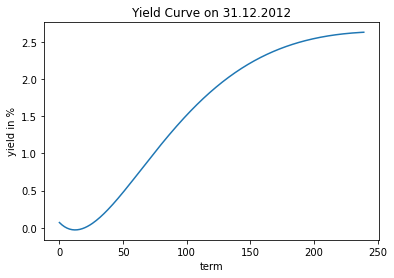

In [6]:
Y=yc(hist_yc(index_yc))
plt.plot(100*Y.yields)
plt.title('Yield Curve on '+ECB.iloc[index_yc-1,0])
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

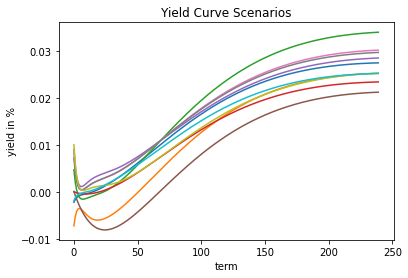

In [7]:
for k in range(int(1e1)):
    plt.plot(Y.yields+target_month*PCA_mu+np.matmul(PCA_Lambda[:,:3],\
        np.random.multivariate_normal(np.zeros(3),np.diag(target_month*\
        PCA_lambda[:3])).reshape(3,1)).flatten())
plt.title('Yield Curve Scenarios')
plt.xlabel('term')
plt.ylabel('yield in %')
plt.show()

## Swap Market

For simplicity, swap tenors in either legs are $1m$. The fixed leg is chosen such that swaps trade at par at issuance. E.g., see the section «Valuation of Interest Rate Swaps» in the textbook «Options, Futures,
and other Derivatives» by John C. Hull for further details.

In [8]:
swap_series=[24,60,120,240]
swap_num = len(swap_series)
class swap:
    def __init__(self,yc,nominal,maturity): #tenor=1
        self.yc = yc
        self.nominal = nominal
        self.maturity = maturity
        self.fixed_leg = np.append(np.repeat(yc.cpn(1,self.maturity),\
            self.maturity),np.repeat(np.zeros(1),N-self.maturity))/12
        self.fixed_volume = np.append(np.repeat(nominal,\
            self.maturity),np.repeat(np.zeros(1),N-self.maturity))
#         self.cash_flows = self.fixed_leg * nominal
        
    def update(self,steps=1):
        self.cash_flows=np.append(self.cash_flows[steps:],np.zeros(steps))

def swap_indicator(maturity):
    return np.reshape(np.append(np.ones(maturity),np.zeros(N-maturity)),(1,N))

In [9]:
#Test
Y = yc(hist_yc(index_yc))
s = swap(Y,0.1,240)
Y.yields[-1]

0.026313157671808297

## Benchmark Strategy of a Retail Bank

For the time being (and this can be relaxed), the deposits of the clients are kept constant and bear no interest. The asset side earns the monthly short rate. However, one could do better, if one incorporated swaps into the ecosystem. The current benchmark follows the strategy «doing nothing».

## Bank do nothing 

In [10]:
def benchmark(nRoutines=nValidation):
    np.random.seed(0)
    output=np.zeros(nRoutines)
    for l in range(nRoutines):
        # yield curve
        Y = yc(hist_yc(index_yc))
        # assets
        A = A0
        L = L0
        for k in range(target_month):
            # market updates
            A *= np.exp(Y.yields[0]/12)
            Y = yc(Y.yields+yc_scn_gen())
            E = A - L
        output[l] = E
    return output

In [11]:
# output_benchmark = benchmark()
# plt.hist(output_benchmark,bins=100,density=True,edgecolor='black',alpha=0.7)
# plt.title('Empirical Probability Density Function')
# plt.xlabel('Equity')
# plt.show()

## Bank with  swap trade

In [12]:
def benchmark_swap(nRoutines=nValidation):
    np.random.seed(0)
    output=np.zeros([nRoutines,target_month+1])
    for l in range(nRoutines):
        output[l,0] = A0
        # yield curve
        Y=yc(hist_yc(index_yc))
        # assets
        A = A0
        L = L0
        E = A-L
        # initial no swap
        fixed_cash_flows = np.zeros(N)
        swap_volume = np.zeros(N)
        for k in range(target_month):
            # Buy swap
            A_liq = A * 0.9 - swap_volume[k]
            for ith, swap_maturity in enumerate(swap_series):
                if target_month - k >= swap_maturity:
                    swap_nominal = A_liq * 0.05
                    s = swap(Y,1,swap_maturity)
                    fixed_cash_flows[k:] += s.fixed_leg[:N-k] * swap_nominal
                    swap_volume[k:] += s.fixed_volume[:N-k] * swap_nominal
            # Market update
            A += (A - swap_volume[k])*(np.exp(Y.yields[0]/12)-1) + fixed_cash_flows[k] 
            E = A-L
            Y = yc(Y.yields+yc_scn_gen())
            output[l,k+1] = A
        
    return output

In [13]:
# output_benchmark_swap = benchmark_swap()
# helper = output_benchmark_swap[:,-1]-L0
# plt.hist(helper,bins=100,density=True,edgecolor='black',alpha=0.7)
# plt.title('Empirical Probability Density Function')
# plt.xlabel('Equity')
# plt.show()

# Deep Learning Hyperparameter Tuning

In [25]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=8e25ac6048bf3e4662b5c650884472052f8392ea53d0ed630a2335f34335b0b8
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=67ecc7f05460fe1ee67264b9c3d0113613f34dda5c0972111d9a651b19273196
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [30]:
import time
import numpy as np 
import matplotlib.pyplot as plt
from importlib import reload 
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import backend as K

import kerastuner as kt
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

In [18]:
def prepare_data(seed = 0, nRoutines = nValidation):
    np.random.seed(seed)
    yields_data = np.zeros([nRoutines,target_month])
    swap_rate_data = np.zeros([nRoutines,target_month,len(swap_series),N])
    swap_volume_data = np.zeros([nRoutines,target_month,len(swap_series),N])
    for l in range(nRoutines):
        Y=yc(hist_yc(index_yc))
        for k in range(target_month):
            yields_data[l,k] = Y.yields[0] 
            for ith, swap_maturity in enumerate(swap_series):
                s = swap(Y,1,swap_maturity)
                swap_rate_data[l,k,ith,k:] = s.fixed_leg[:N-k] 
                swap_volume_data[l,k,ith,k:] = s.fixed_volume[:N-k] 
            Y=yc(Y.yields+yc_scn_gen())
    inputs_X = [yields_data, swap_rate_data, swap_volume_data]
    inputs_Y = np.zeros([nRoutines]) + target_equity 
    return inputs_X, inputs_Y

In [29]:
def build_model_tuner(hp):
    # Network
    Networks = []
    for k in range(target_month):
        n_output = swap_av[k]
        if n_output > 0:
          model_n = Sequential()
          model_n.add(Dense(hp.Int('Dense_0', 10, 50, 10), input_shape=(7,)))
          model_n.add(BatchNormalization())
          model_n.add(Activation('relu'))

          for i in range(hp.Int('Layers', 1, 3)):
            model_n.add(Dense(hp.Int(f'Dense_{i+1}', 10, 50, 10)))
            model_n.add(BatchNormalization())
            model_n.add(Activation('relu'))

          model_n.add(Dense(n_output))
          model_n.add(BatchNormalization())
          model_n.add(Activation('softmax'))

          Networks.append(model_n)

    yields_data = keras.Input(shape=(target_month)) 
    swap_rate_data = keras.Input(shape=(target_month,swap_num,N))
    swap_volume_data = keras.Input(shape=(target_month,swap_num,N))
    batch_size = tf.shape(yields_data)[0]
    
    A = tf.zeros(batch_size) + A0 
    L = tf.zeros(batch_size) + L0
    
    fixed_cash_flows = tf.zeros([batch_size,N])
    swap_volume = tf.zeros([batch_size,N])
    
    A_list = [None] * (target_month+1)
    A_liq_list = [None] * target_month # Just to record if we break restriction 
    A_list[0] = A 
    cons_loss = tf.zeros(batch_size)
    for k in range(target_month):
        # Restriction loss
        cons_loss += hp.Int('Const', 10, 100, 10) * tf.nn.relu(tf.nn.relu(swap_volume[:,k]) - 0.9 * A_list[k]) 
        
        # Before rebalance 
        A_liq_list[k] = 0.9 * A_list[k] - swap_volume[:,k]
        
        info_list = [yields_data[:,k:k+1], 
                     swap_rate_data[:,k,:,k],
                     fixed_cash_flows[:,k:k+1],
                     swap_volume[:,k:k+1]
                    ]            
        info = tf.concat(info_list,axis = -1)
        
        if swap_av[k] > 0:
            strategy = Networks[k](info) * tf.tile(A_liq_list[k][:,None],[1,swap_av[k]]) 
            fixed_cash_flows += tf.reduce_sum(swap_rate_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1)
            swap_volume += tf.reduce_sum(swap_volume_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1) # re-valuation of swap
        # Market update  
        A_list[k+1] = A_list[k] + (A_list[k] - swap_volume[:,k])*(tf.exp(yields_data[:,k]/12) - 1) + fixed_cash_flows[:,k]
    
    E = A_list[-1] - L    
    
    inputs = [yields_data, swap_rate_data, swap_volume_data]
    outputs = E + cons_loss 
    model = keras.Model(inputs = inputs, outputs = outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    target_E = tf.zeros(batch_size) + target_equity
    loss1 = mse(E,target_E)
    model.add_loss(loss1)
    
    cons_loss_helper = tf.zeros(batch_size)
    loss2 = mse(cons_loss,cons_loss_helper)
    model.add_loss(loss2)
    model.add_metric(loss2, name='restriction_loss')

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1) # specify the optimizer 
    model.compile(optimizer=optimizer, loss=zeroloss) 
    
    return model

In [20]:
swap_av = np.zeros(N)
for maturity in swap_series:
    diff = target_month - maturity
    if diff >= 0:
        swap_av[0:diff+11] += 1
swap_av = swap_av.astype('int')

In [21]:
swap_av = np.zeros(N)
swap_av[:target_month] += 4
swap_av = swap_av.astype('int')

In [22]:
inputs_X, inputs_Y = prepare_data()

In [23]:
def zeroloss(y_true, y_predict):
    return tf.reduce_sum(y_true*0)

In [27]:
early_stopping_tuner = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                        verbose=1,
                                                        patience=5,
                                                        mode='min',
                                                        restore_best_weights=True)

In [ ]:
"""tuner = kt.Hyperband(build_model_tuner,
                     objective=kt.Objective('loss', direction='min'),
                     max_epochs=30,
                     factor=3,
                     directory=f'{time.time()}'
                     )"""

tuner = BayesianOptimization(build_model_tuner,
                             objective=kt.Objective('loss', direction='min'),
                             max_trials=100,
                             seed=12,
                             directory=f'{time.time()}')

tuner.search(inputs_X, 
             inputs_Y, 
             epochs=30, 
             callbacks=[early_stopping_tuner])

Trial 1 Complete [00h 11m 52s]
loss: 1.5327612161636353

Best loss So Far: 1.5327612161636353
Total elapsed time: 00h 11m 52s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
Dense_0           |20                |30                
Layers            |2                 |2                 
Dense_1           |20                |10                
Const             |70                |100               
Dense_2           |50                |10                

Epoch 1/30
32/32 [==============================] - 196s 442ms/step - loss: 6.5946 - restriction_loss: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 14s 441ms/step - loss: 2.4669 - restriction_loss: 0.0000e+00
Epoch 3/30
32/32 [==============================] - 14s 440ms/step - loss: 2.1037 - restriction_loss: 0.0000e+00
Epoch 4/30
32/32 [==============================] - 14s 443ms/step - loss: 1.9589 - restriction_loss: 0.0000e+00
Epoch 5/30
32/32 [==============================] -

In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_hps = tuner.get_best_hyperparameters(num_models=1)[0]

# Testing

In [24]:
inputs_X_test, inputs_Y_test = prepare_data(2021)

In [ ]:
def build_network(n_input, n_hidden, time_steps):
# architecture is the same for all networks
    # Network
    Networks = []
    for k in range(target_month):
        n_output = swap_av[k]
        if n_output > 0:
          model_n = Sequential()
          model_n.add(Dense(best_hps['Dense_0'], input_shape=(7,)))
          model_n.add(BatchNormalization())
          model_n.add(Activation('relu'))

          for i in range(best_hps['Layers']):
            model_n.add(Dense(best_hps[f'Dense_{i+1}'], 10, 50, 10)))
            model_n.add(BatchNormalization())
            model_n.add(Activation('relu'))

          model_n.add(Dense(n_output))
          model_n.add(BatchNormalization())
          model_n.add(Activation('softmax'))

          Networks.append(model_n)
      return Networks

In [ ]:
def build_graph():
    yields_data = keras.Input(shape=(target_month)) 
    swap_rate_data = keras.Input(shape=(target_month,swap_num,N))
    swap_volume_data = keras.Input(shape=(target_month,swap_num,N))
    batch_size = tf.shape(yields_data)[0]
    
    A = tf.zeros(batch_size) + A0 
    L = tf.zeros(batch_size) + L0
    
    fixed_cash_flows = tf.zeros([batch_size,N])
    swap_volume = tf.zeros([batch_size,N])
    
    A_list = [None] * (target_month+1)
    A_liq_list = [None] * target_month # Just to record if we break restriction 
    A_list[0] = A 
    cons_loss = tf.zeros(batch_size)
    for k in range(target_month):
        # Restriction loss
        cons_loss += 100 * tf.nn.relu(tf.nn.relu(swap_volume[:,k]) - 0.9 * A_list[k]) 
        
        # Before rebalance 
        A_liq_list[k] = 0.9 * A_list[k] - swap_volume[:,k]
        
        info_list = [yields_data[:,k:k+1], 
                     swap_rate_data[:,k,:,k],
                     fixed_cash_flows[:,k:k+1],
                     swap_volume[:,k:k+1]
                    ]            
        info = tf.concat(info_list,axis = -1)
        
        if swap_av[k] > 0:
            strategy = Networks[k](info) * tf.tile(A_liq_list[k][:,None],[1,swap_av[k]]) 
            fixed_cash_flows += tf.reduce_sum(swap_rate_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1)
            swap_volume += tf.reduce_sum(swap_volume_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1) # re-valuation of swap
        # Market update  
        A_list[k+1] = A_list[k] + (A_list[k] - swap_volume[:,k])*(tf.exp(yields_data[:,k]/12) - 1) + fixed_cash_flows[:,k]
    
    E = A_list[-1] - L    
    
    inputs = [yields_data, swap_rate_data, swap_volume_data]
    outputs = E + cons_loss 
    model = keras.Model(inputs = inputs, outputs = outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    target_E = tf.zeros(batch_size) + target_equity
    loss1 = mse(E,target_E)
    model.add_loss(loss1)
    
    
    cons_loss_helper = tf.zeros(batch_size)
    loss2 = mse(cons_loss,cons_loss_helper)
    model.add_loss(loss2)
    model.add_metric(loss2, name='restriction_loss')
    
    return model

model = build_graph()

In [ ]:
HOLD = []
HOLDprop = []
yields_data, swap_rate_data, swap_volume_data = inputs_X_test
yields_data = yields_data.astype('float32')
swap_rate_data = swap_rate_data.astype('float32')
swap_volume_data = swap_volume_data.astype('float32')

batch_size = tf.shape(yields_data)[0]
    
A = tf.zeros(batch_size) + A0 
L = tf.zeros(batch_size) + L0

fixed_cash_flows = tf.zeros([batch_size,N])
swap_volume = tf.zeros([batch_size,N])

A_list = [None] * (target_month+1)
A_liq_list = [None] * target_month # Just to record if we break restriction 
A_list[0] = A 
cons_loss = tf.zeros(batch_size)
for k in range(target_month):
    # Restriction loss
    cons_loss += 10 * tf.nn.relu(tf.nn.relu(swap_volume[:,k]) - 0.9 * A_list[k]) 

    # Before rebalance 
    A_liq_list[k] = 0.9 * A_list[k] - swap_volume[:,k]

    info_list = [yields_data[:,k:k+1], 
                 swap_rate_data[:,k,:,k],
                 fixed_cash_flows[:,k:k+1],
                 swap_volume[:,k:k+1]
                ]            
    info = tf.concat(info_list,axis = -1)

    if swap_av[k] > 0:
        strategy = Networks[k](info) * tf.tile(A_liq_list[k][:,None],[1,swap_av[k]]) 
        HOLDprop.append(Networks[k](info))
        HOLD.append(tf.reduce_sum(strategy,axis = -1))
        fixed_cash_flows += tf.reduce_sum(swap_rate_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1)
        swap_volume += tf.reduce_sum(swap_volume_data[:,k,:swap_av[k],:] * strategy[:,:,None], axis = 1) # re-valuation of swap
    # Market update  
    A_list[k+1] = A_list[k] + (A_list[k] - swap_volume[:,k])*(tf.exp(yields_data[:,k]/12) - 1) + fixed_cash_flows[:,k]

E = A_list[-1] - L

In [ ]:
plt.figure(figsize = [12,5])
plt.grid()
plt.hist(E.numpy(),bins=100,density=True,edgecolor='black',alpha=0.7)
# plt.xlim([50, 90])
plt.title('Empirical Probability Density Function')
plt.xlabel('Equity')
plt.show()